# Analyzing salary survey and predicting salary using a linear regression model


The original dataset comes from the Ask a Manager Survey

> The salary survey a few weeks ago got a huge response — 24,000+ people shared their salaries and other info, which is a lot of raw data to sift through. Reader Elisabeth Engl kindly took the raw data and analyzed some of the trends in it and here’s what she found. (She asked me to note that she did this as a fun project to share some insights from the survey, rather than as a paid engagement.)

> This data does not reflect the general population; it reflects Ask a Manager readers who self-selected to respond, which is a very different group (as you can see just from the demographic breakdown below, which is very white and very female).



The cleaned dataset is provided by the [Tidy Tuesday project](https://github.com/rfordatascience/tidytuesday/blob/master/data/2021/2021-05-18/readme.md)

## Loading the data


In [191]:
import fsspec
import pandas as pd
from plotnine import (
    ggplot,
    geom_point,
    aes,
    stat_smooth,
    facet_wrap,
    scale_x_log10,
    geom_histogram,
    labels,
    labs,
)
import janitor
import proplot as pplt
import seaborn as sns

In [192]:
pplt.rc["figure.figsize"] = (8, 6)
pplt.rc["figure.dpi"] = 100
pplt.rc['font.size'] = 6

In [193]:
# instantiate an fsspec filesystem object w/ caching enabled
fs = fsspec.filesystem("filecache", target_protocol="https", cache_storage="/tmp/files")

# load the data into pandas
data = pd.read_csv(
    fs.open(
        'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-05-18/survey.csv'
    ),
    parse_dates=['timestamp'],
)
data.head()

,timestamp,how_old_are_you,industry,job_title,additional_context_on_job_title,annual_salary,other_monetary_comp,currency,currency_other,additional_context_on_income,country,state,city,overall_years_of_professional_experience,years_of_experience_in_field,highest_level_of_education_completed,gender,race
0,2021-04-27 11:02:10,25-34,Education (Higher Education),Research and Instruction Librarian,NaN,55000,0.0,USD,NaN,NaN,United States,Massachusetts,Boston,5-7 years,5-7 years,Master's degree,Woman,White
1,2021-04-27 11:02:22,25-34,Computing or Tech,Change & Internal Communications Manager,NaN,54600,4000.0,GBP,NaN,NaN,United Kingdom,NaN,Cambridge,8 - 10 years,5-7 years,College degree,Non-binary,White
2,2021-04-27 11:02:38,25-34,"Accounting, Banking & Finance",Marketing Specialist,NaN,34000,NaN,USD,NaN,NaN,US,Tennessee,Chattanooga,2 - 4 years,2 - 4 years,College degree,Woman,White
3,2021-04-27 11:02:41,25-34,Nonprofits,Program Manager,NaN,62000,3000.0,USD,NaN,NaN,USA,Wisconsin,Milwaukee,8 - 10 years,5-7 years,College degree,Woman,White
4,2021-04-27 11:02:42,25-34,"Accounting, Banking & Finance",Accounting Manager,NaN,60000,7000.0,USD,NaN,NaN,US,South Carolina,Greenville,8 - 10 years,5-7 years,College degree,Woman,White


This dataset has 18 columns:

In [194]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26232 entries, 0 to 26231
Data columns (total 18 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   timestamp                                 26232 non-null  datetime64[ns]
 1   how_old_are_you                           26232 non-null  object        
 2   industry                                  26173 non-null  object        
 3   job_title                                 26232 non-null  object        
 4   additional_context_on_job_title           6763 non-null   object        
 5   annual_salary                             26232 non-null  int64         
 6   other_monetary_comp                       19447 non-null  float64       
 7   currency                                  26232 non-null  object        
 8   currency_other                            166 non-null    object        
 9   additional_context_on_income

let's look at the number of missing values in each column:

In [195]:
data.isna().sum() / len(data)

timestamp                                   0.000000
how_old_are_you                             0.000000
industry                                    0.002249
job_title                                   0.000000
additional_context_on_job_title             0.742185
annual_salary                               0.000000
other_monetary_comp                         0.258654
currency                                    0.000000
currency_other                              0.993672
additional_context_on_income                0.890515
country                                     0.000000
state                                       0.178675
city                                        0.002973
overall_years_of_professional_experience    0.000000
years_of_experience_in_field                0.000000
highest_level_of_education_completed        0.007472
gender                                      0.005642
race                                        0.005566
dtype: float64

from this we can see that the columns `currency_other` and `additional_context_on_income` and `additional_context_on_job_title` have a lot of missing values, so we will drop them during the cleaning process. 

In [196]:
df = data.drop(
    columns=['currency_other', 'additional_context_on_income', 'additional_context_on_job_title']
)

## Categorical data

The dataset contains quite a few categorical variables, let's look at the frequency of each category in each categorical variable:

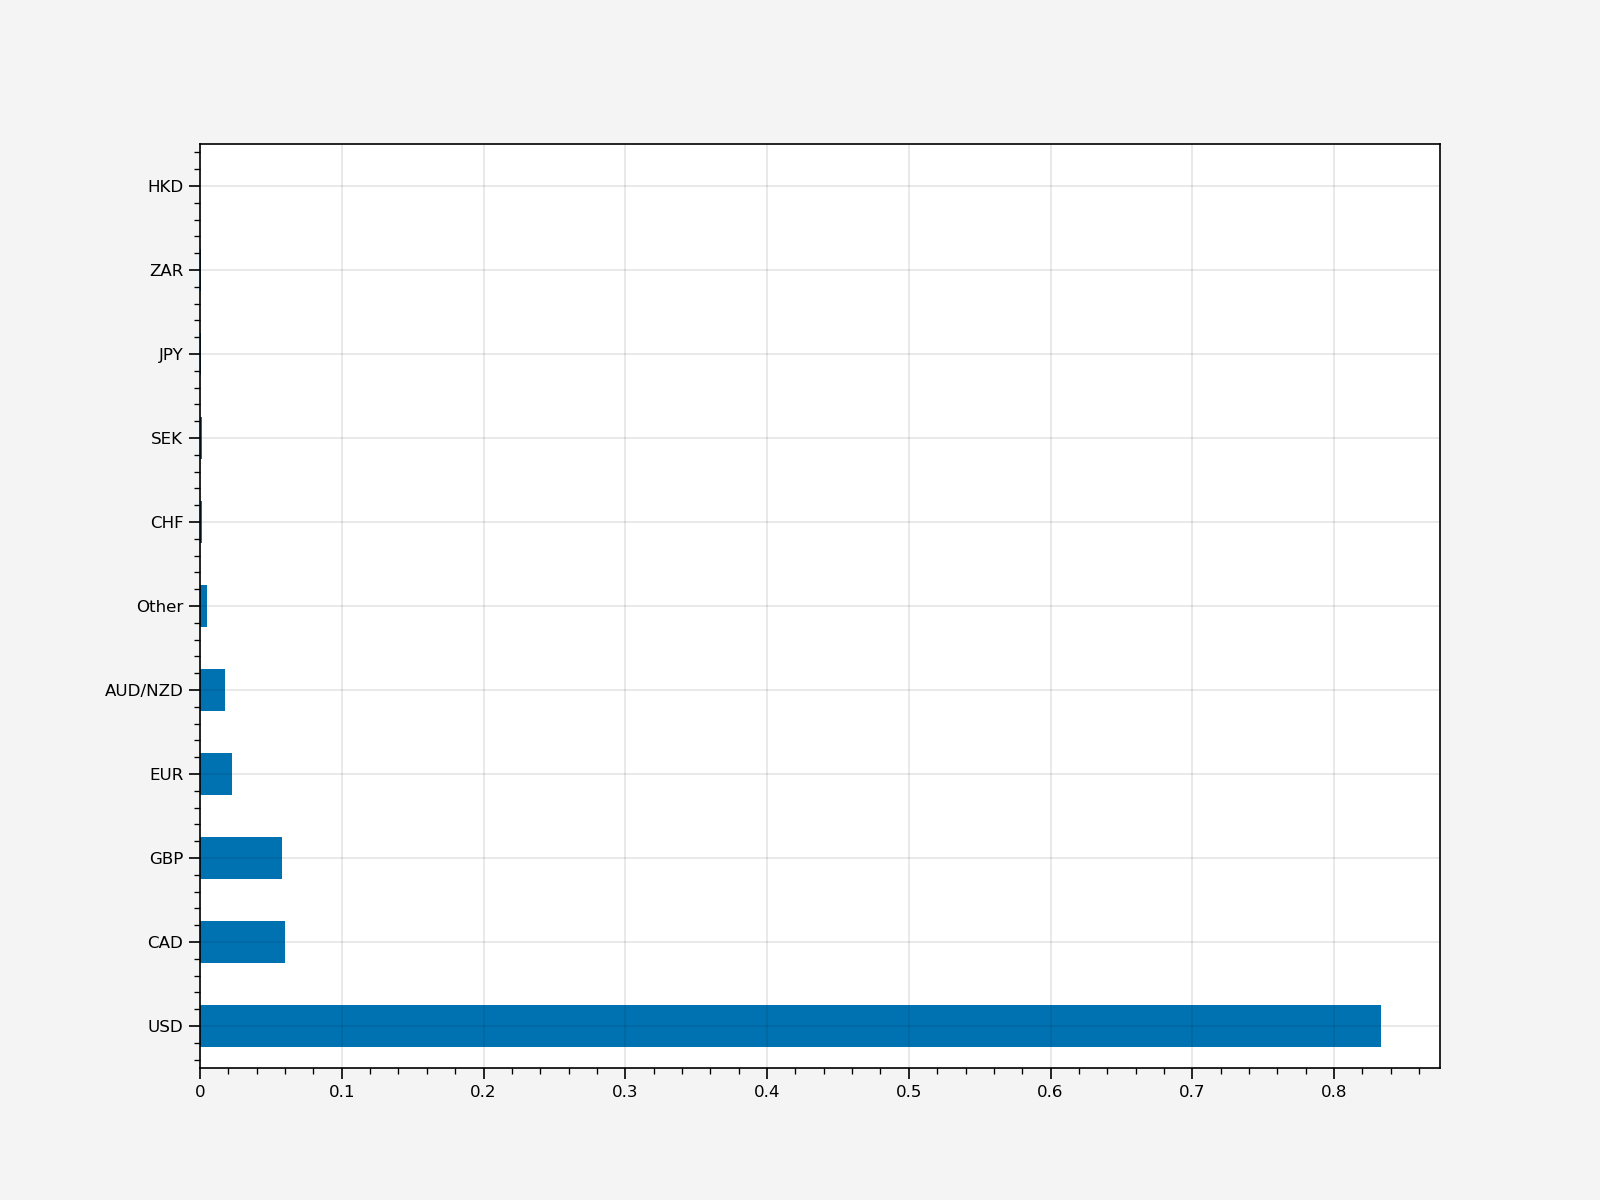

In [197]:
currency_count = df['currency'].value_counts(normalize=True)
currency_count.plot(kind='barh');

From this we notice a few things:

- The majority of respondents reported their salary in USD, followed by CAD and GBP. This hints that the survey was mostly taken by people from the US, Canada and the UK. 
- For our analysis, we will only consider the respondents who reported their salary in USD. By dropping the other currencies, we will be able to use the `salary` values without having to convert them to a common currency. 

In [198]:
# Drop rows with currency other than USD

df = df.filter_on('currency == "USD"')

let's look at the demographics of the population that participated in this survey

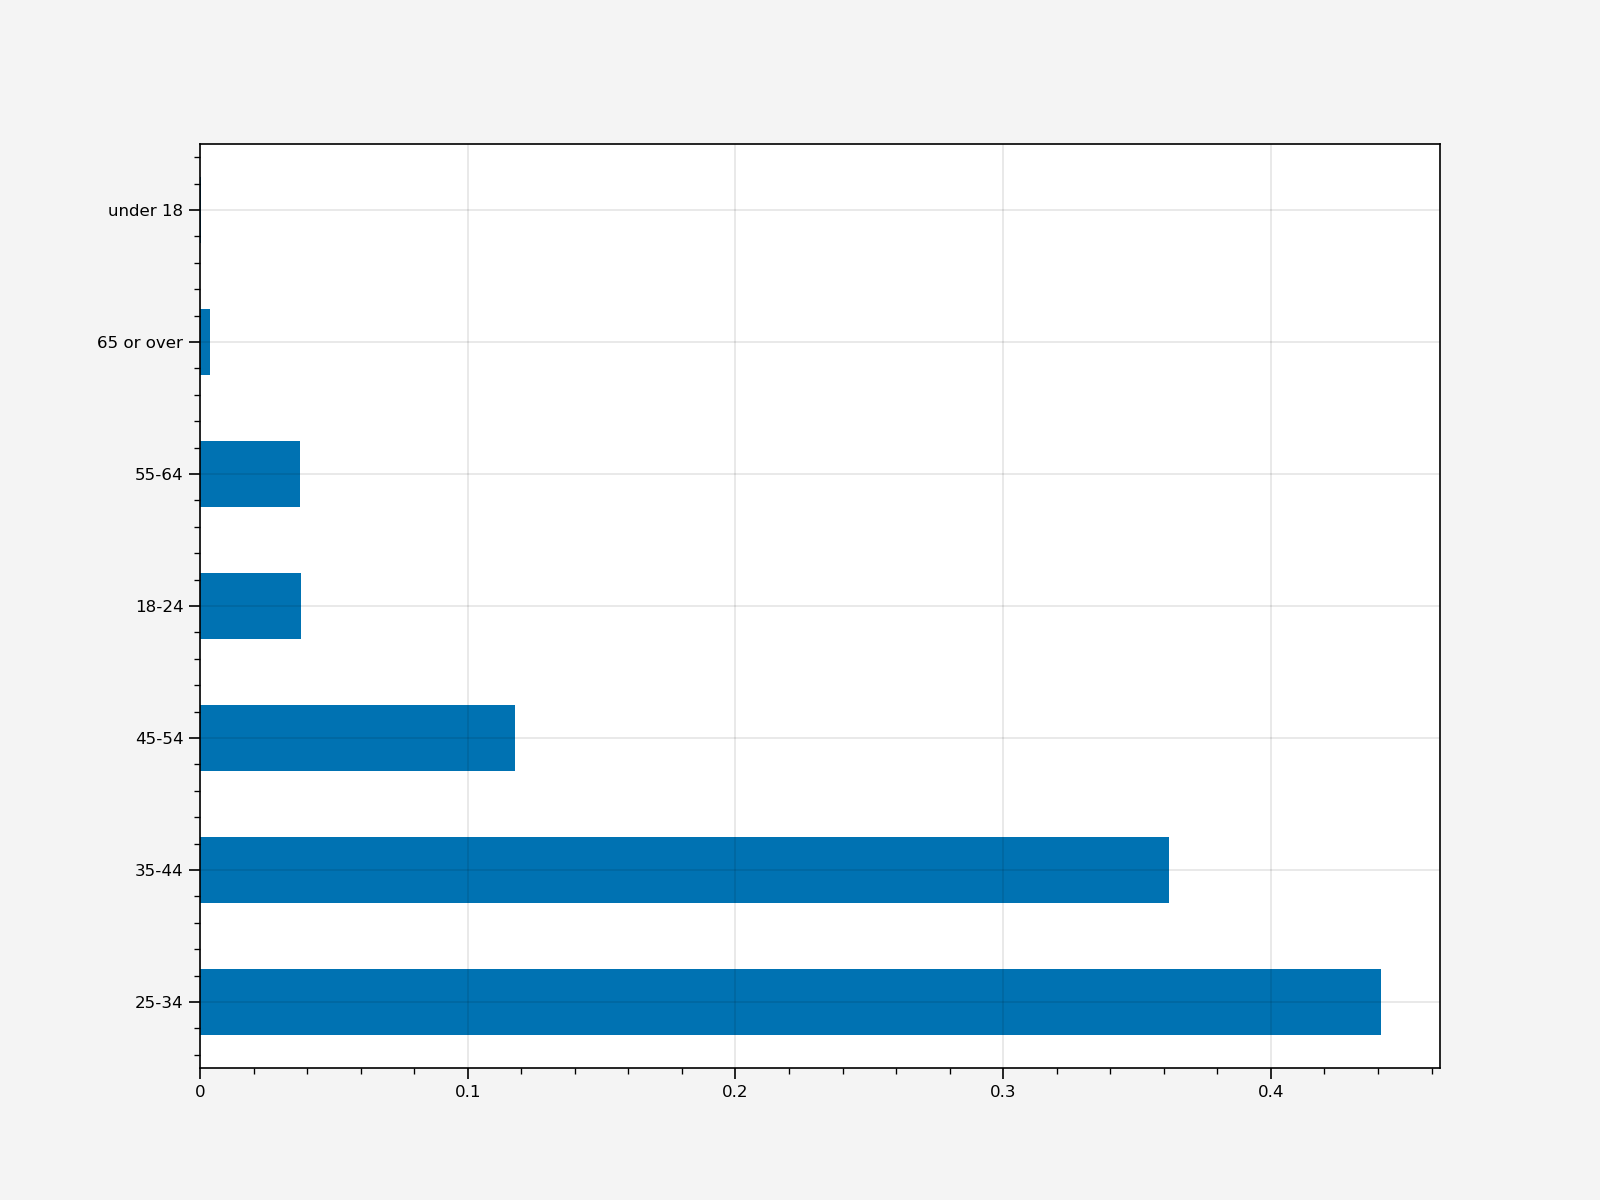

In [199]:
df.how_old_are_you.value_counts(normalize=True).plot(kind='barh');

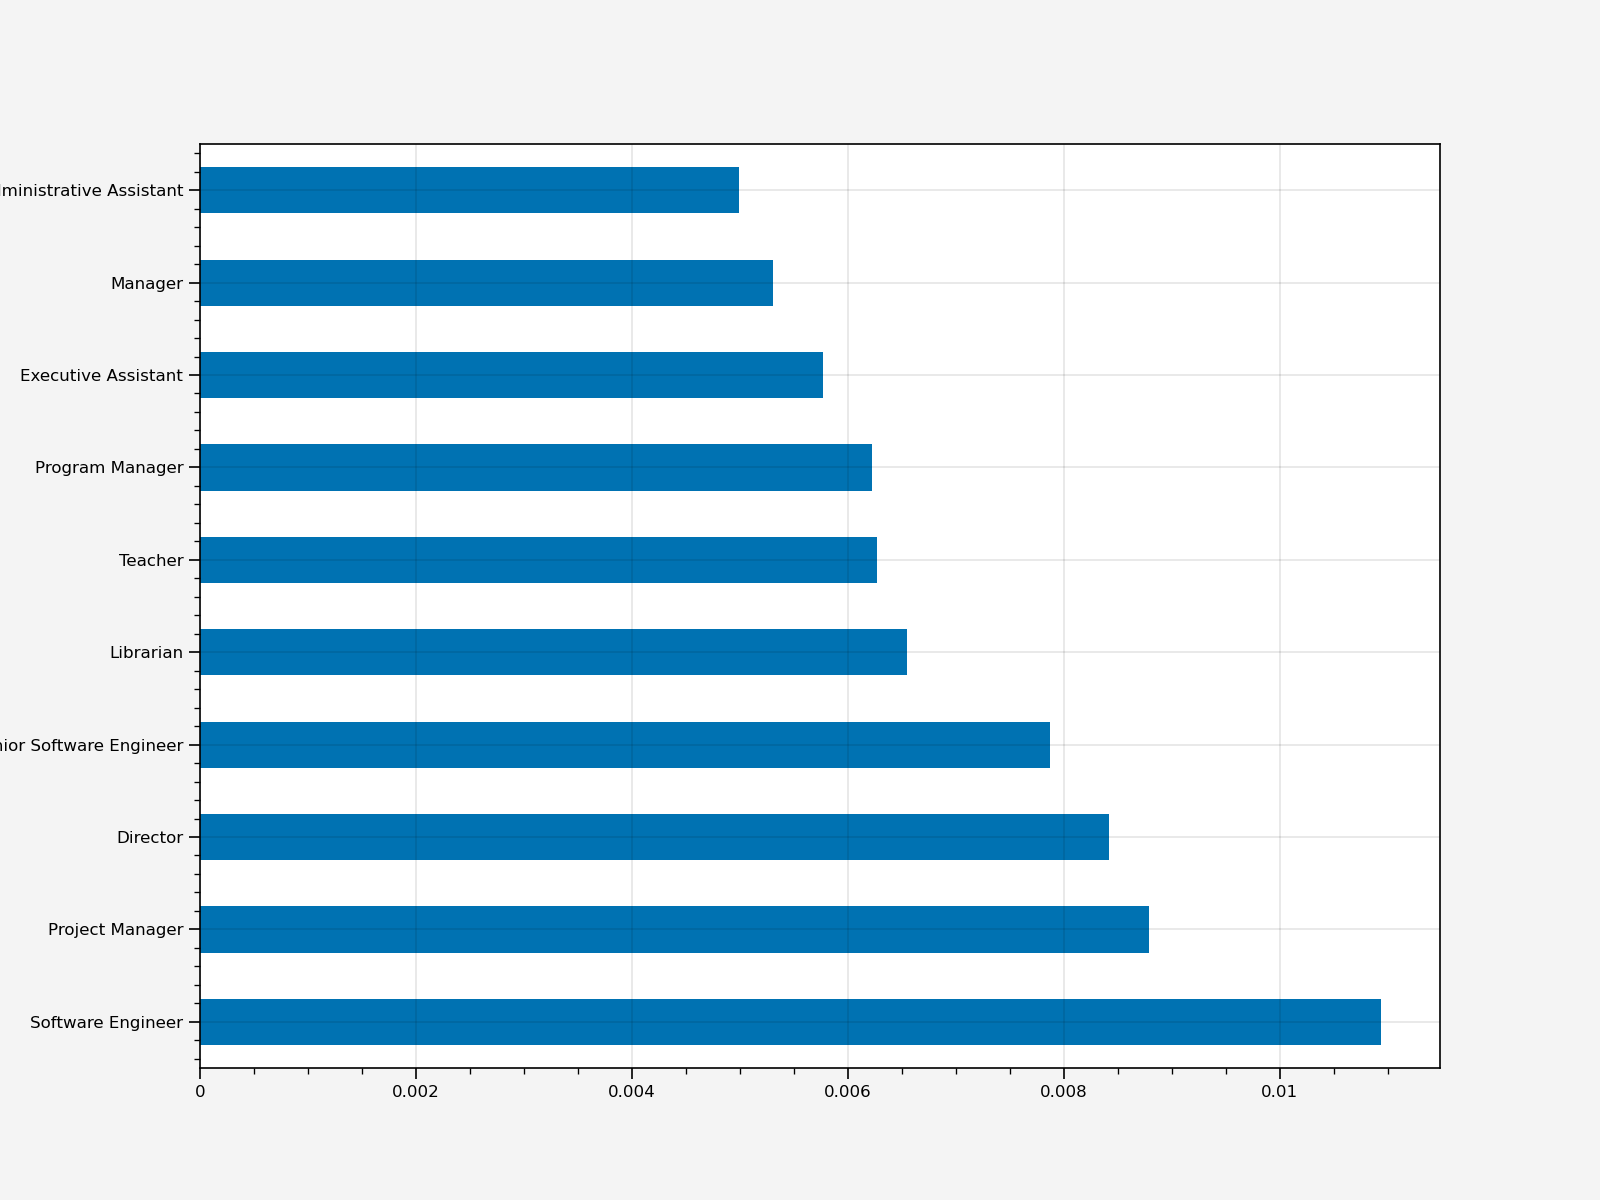

In [200]:
df.job_title.value_counts(normalize=True).nlargest(10).plot(kind='barh');

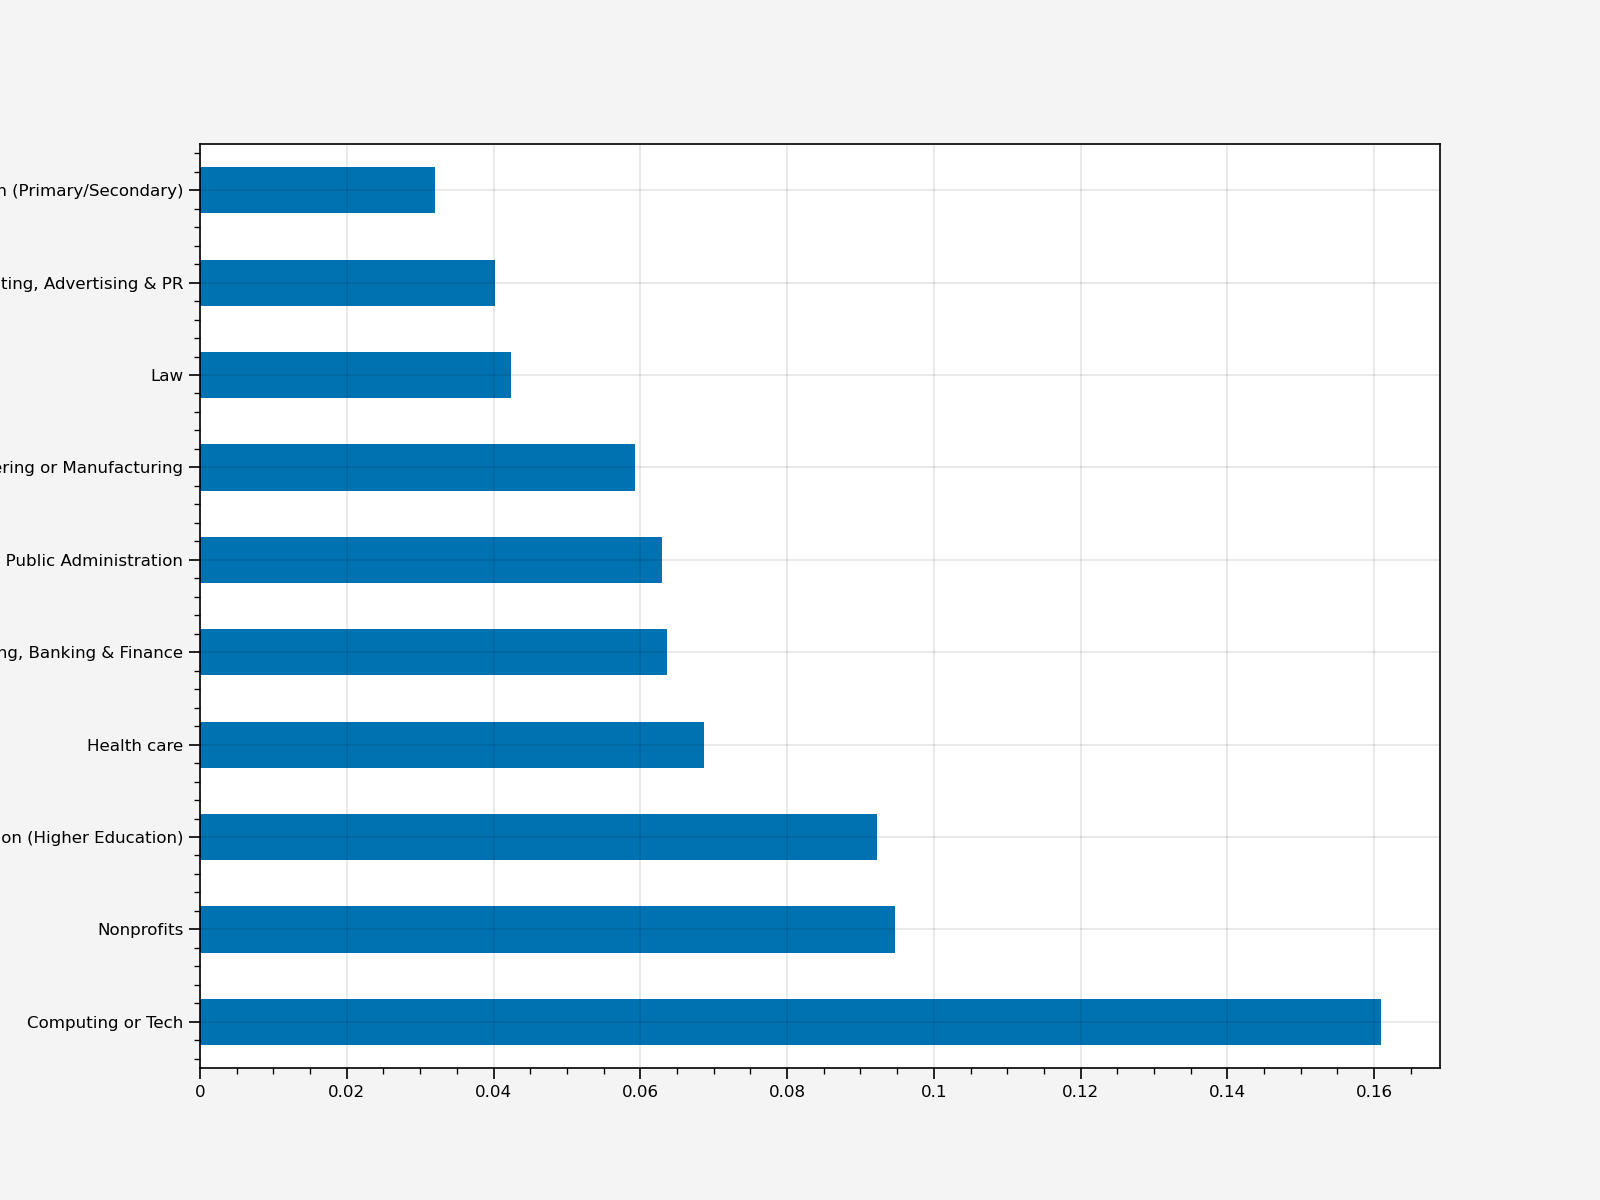

In [201]:
df.industry.value_counts(normalize=True).nlargest(10).plot(kind='barh');

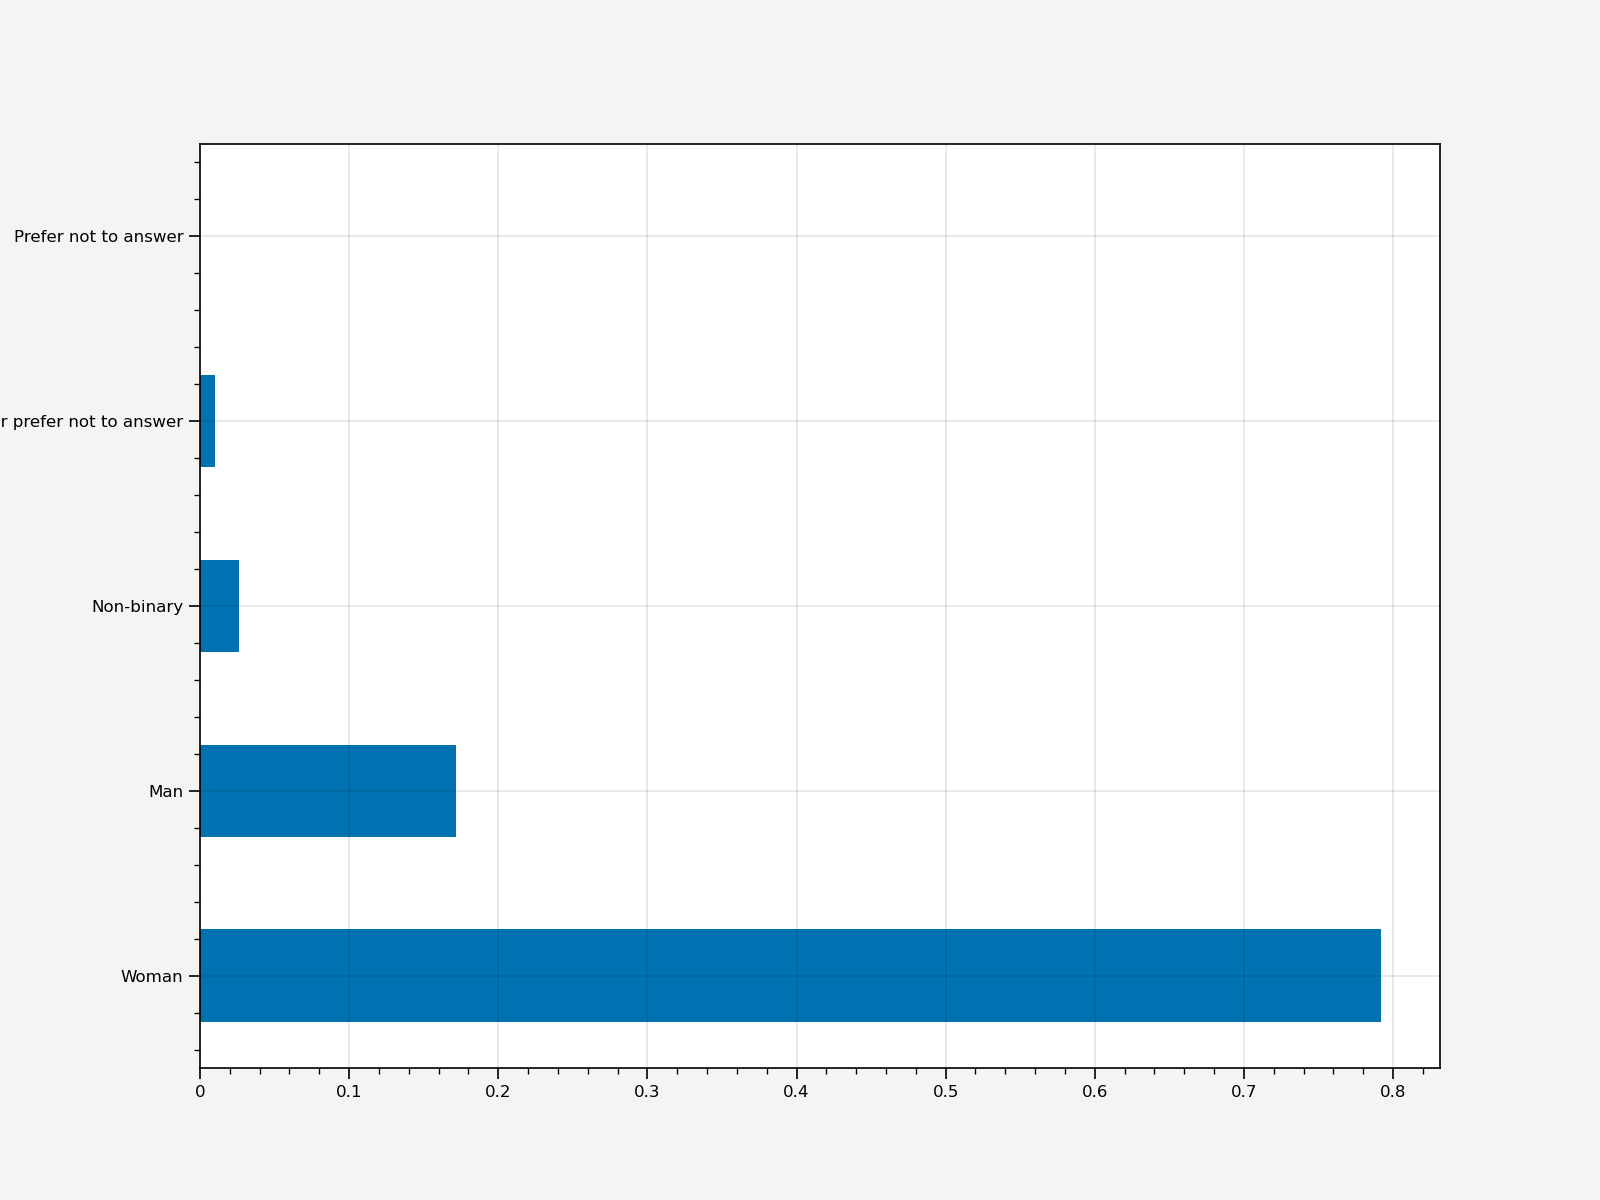

In [202]:
df.gender.value_counts(normalize=True).plot(kind='barh');

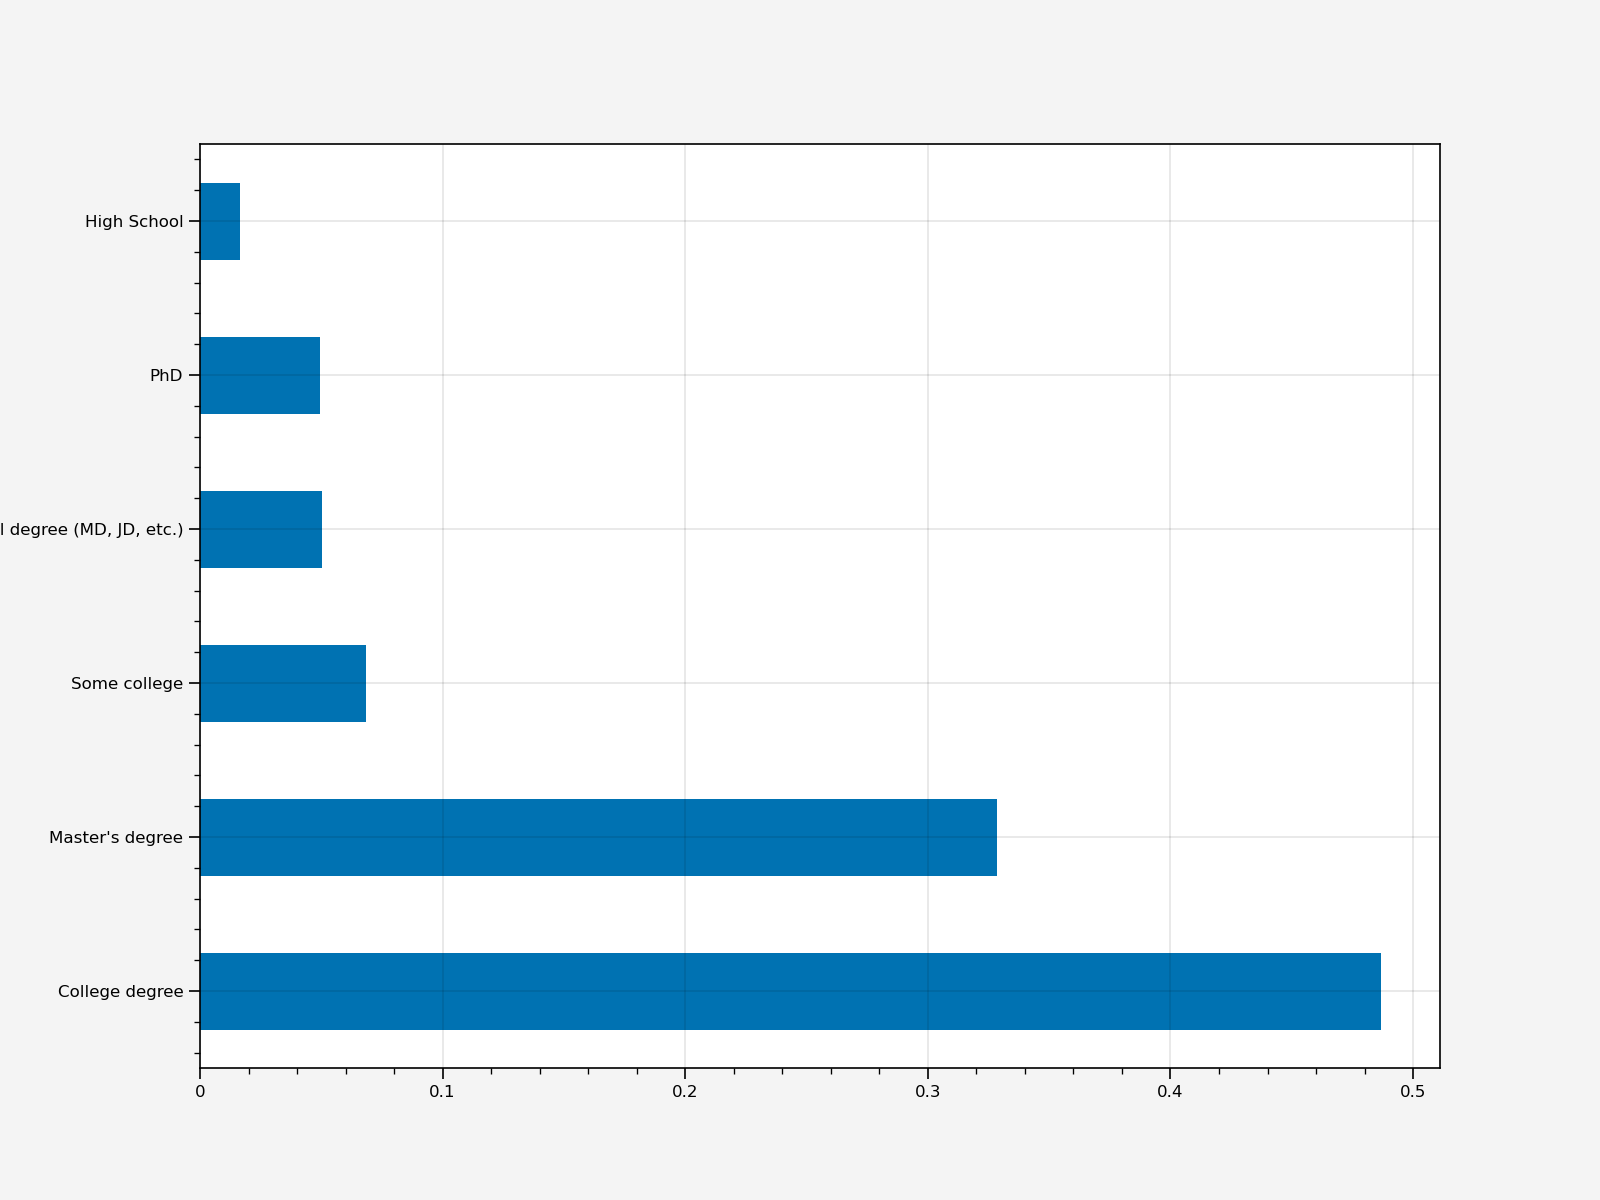

In [203]:
df.highest_level_of_education_completed.value_counts(normalize=True).plot(kind='barh');

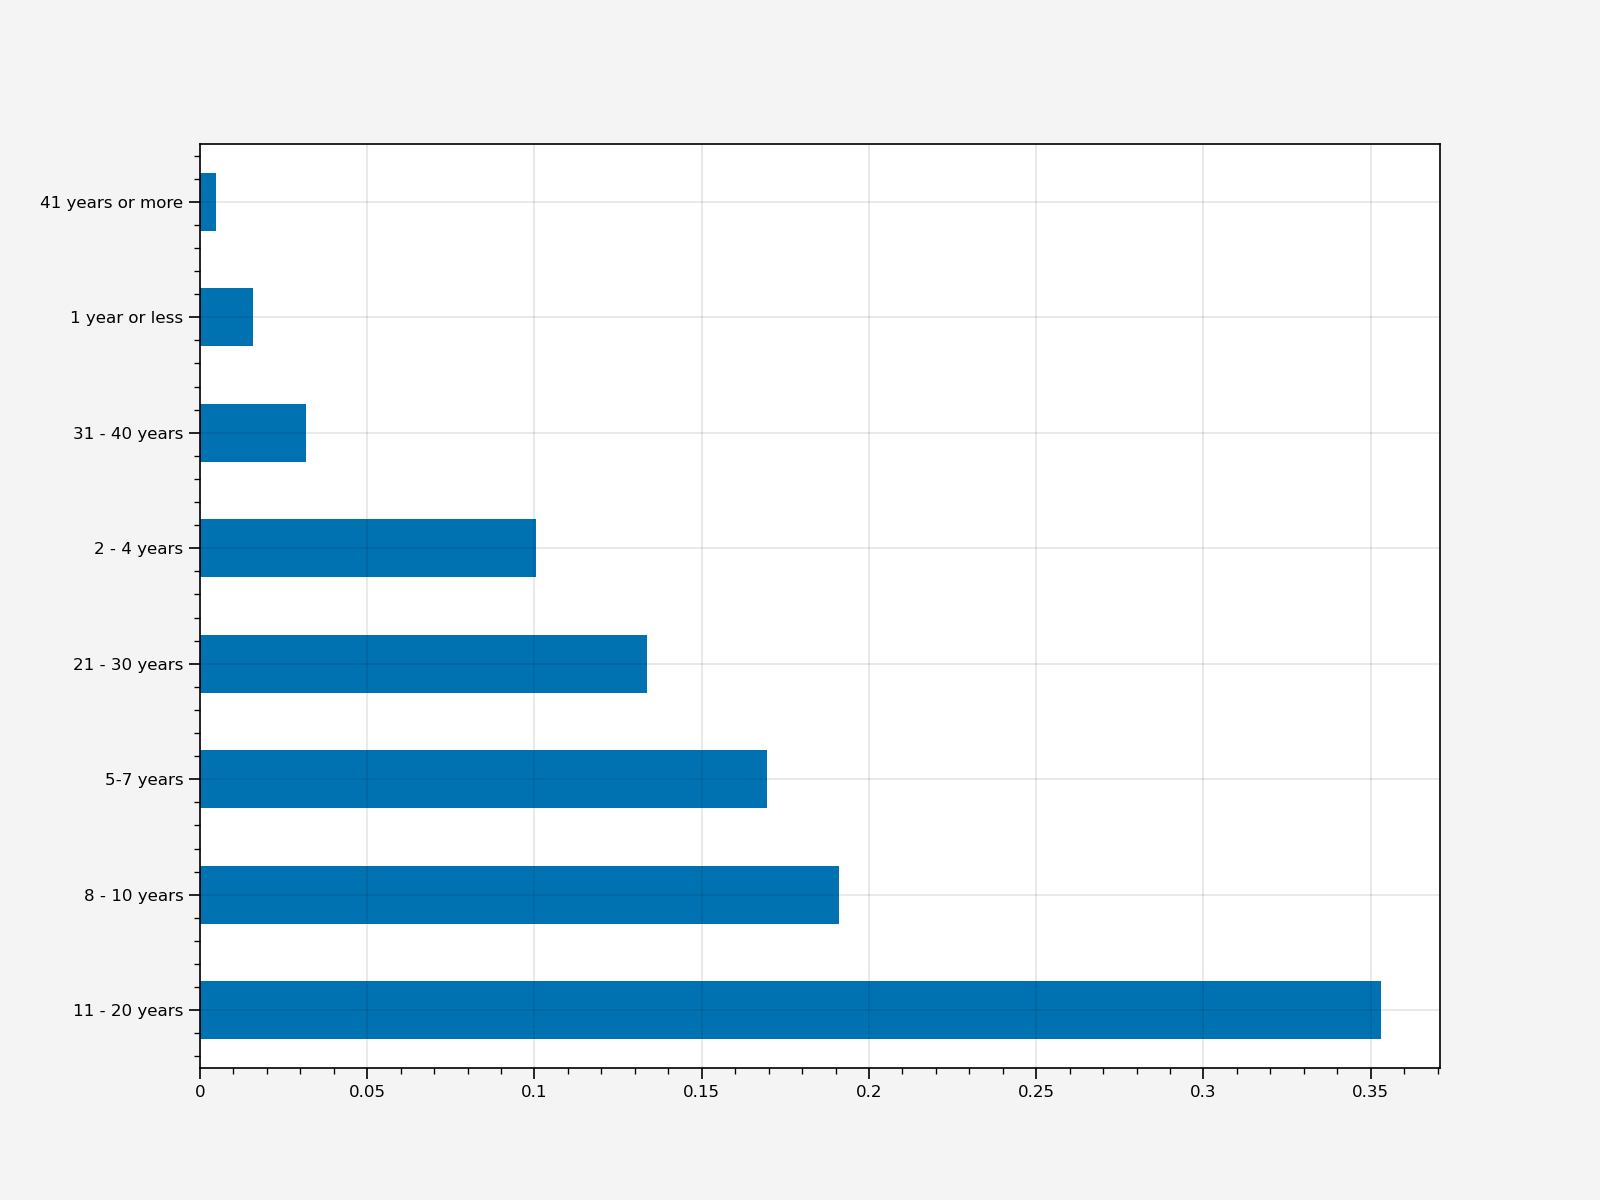

In [204]:
df.overall_years_of_professional_experience.value_counts(normalize=True).plot(kind='barh');

From these frequency plots, we notice that 

- most of the respondents are predominantly **women**, with a **college degree**, and considerable working experience in their field. 
- by looking at the `job title`, it appears we have more responses from software engineers.

## Continuous data

let's look at the distribution of the continuous variables:


In [205]:
df.annual_salary.describe()

count    2.185200e+04
mean     9.665852e+04
std      6.924487e+05
min      0.000000e+00
25%      5.640000e+04
50%      7.899950e+04
75%      1.120000e+05
max      1.020000e+08
Name: annual_salary, dtype: float64

In [206]:
data_usd = df.filter_on("annual_salary >= 5000")

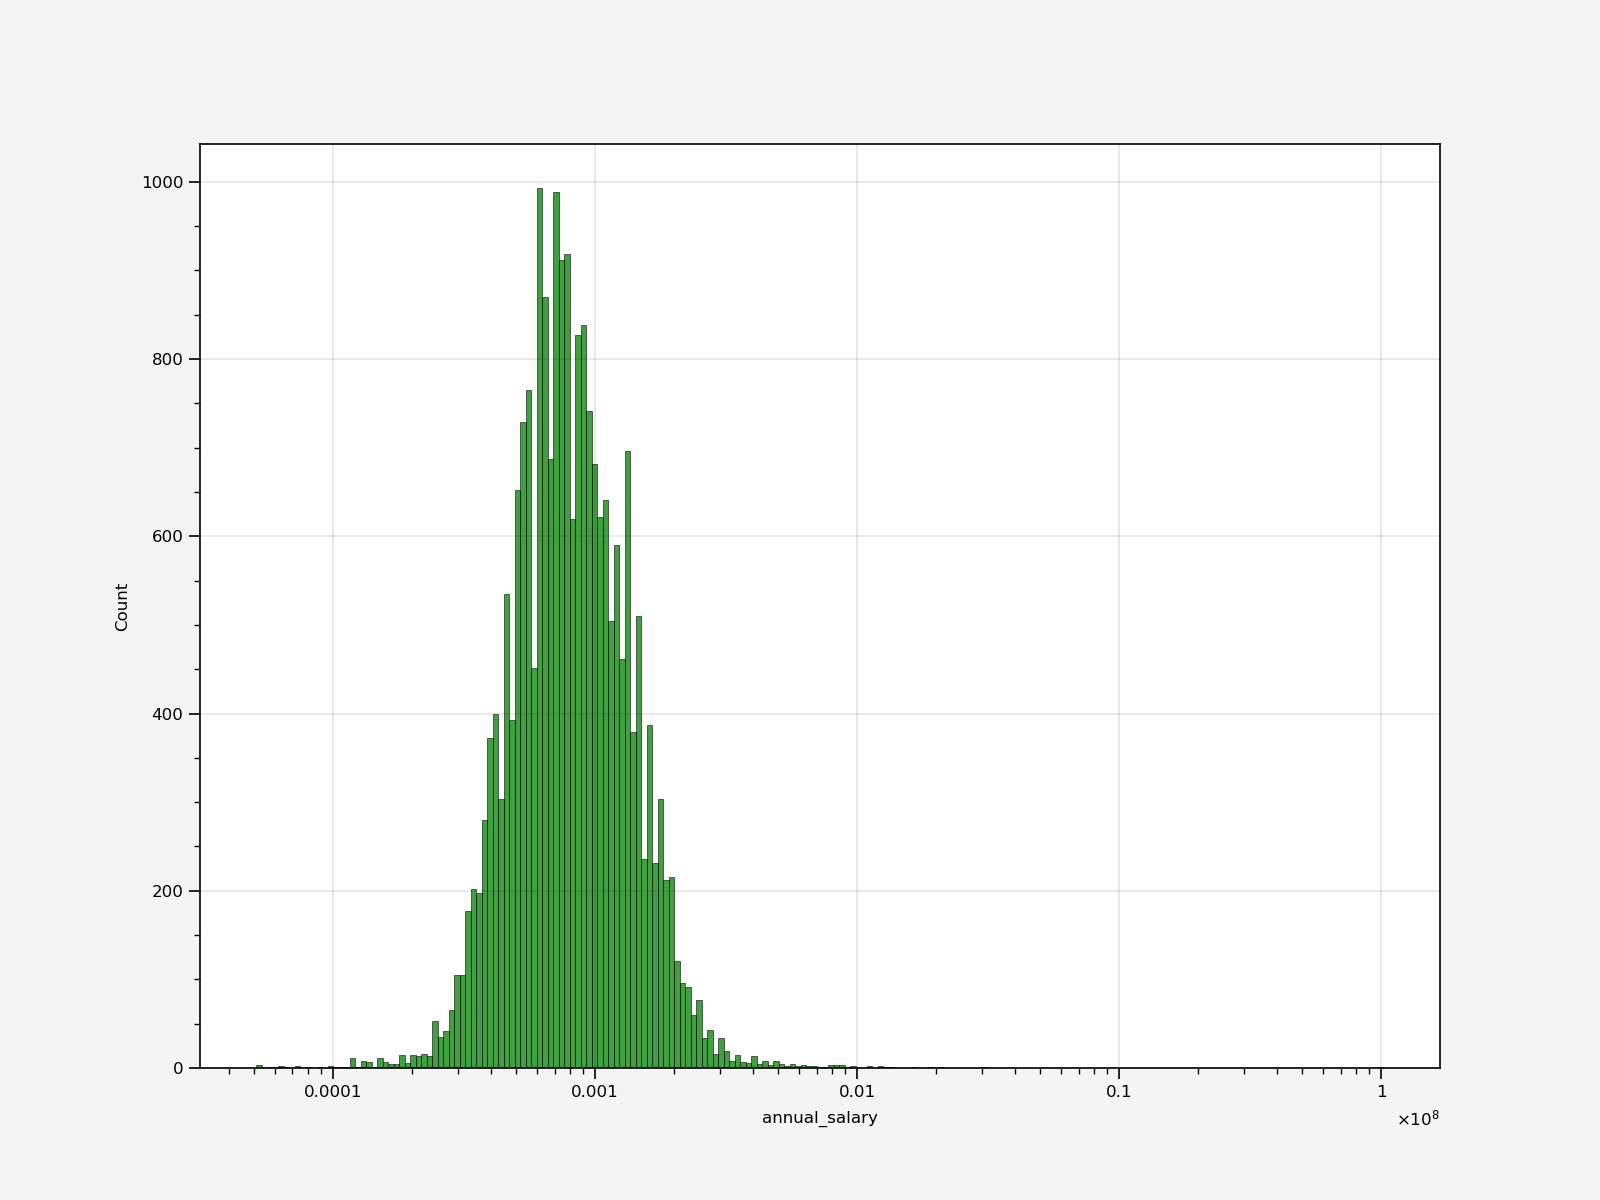

In [207]:
sns.histplot(data=data_usd, x="annual_salary", color='green', log_scale=True);

This shows that the `annual_salary` is skewed to the left, and some outliers are present on both ends of the distribution. To get rid of the outliers, let's remove the values that are more than 3 standard deviations away from the mean.



In [208]:
mean = data_usd.annual_salary.mean()
std = data_usd.annual_salary.std()

data_usd = data_usd.filter_on(f"annual_salary >= {mean - 3 * std}").filter_on(
    f"annual_salary <= {mean + 3 * std}"
)

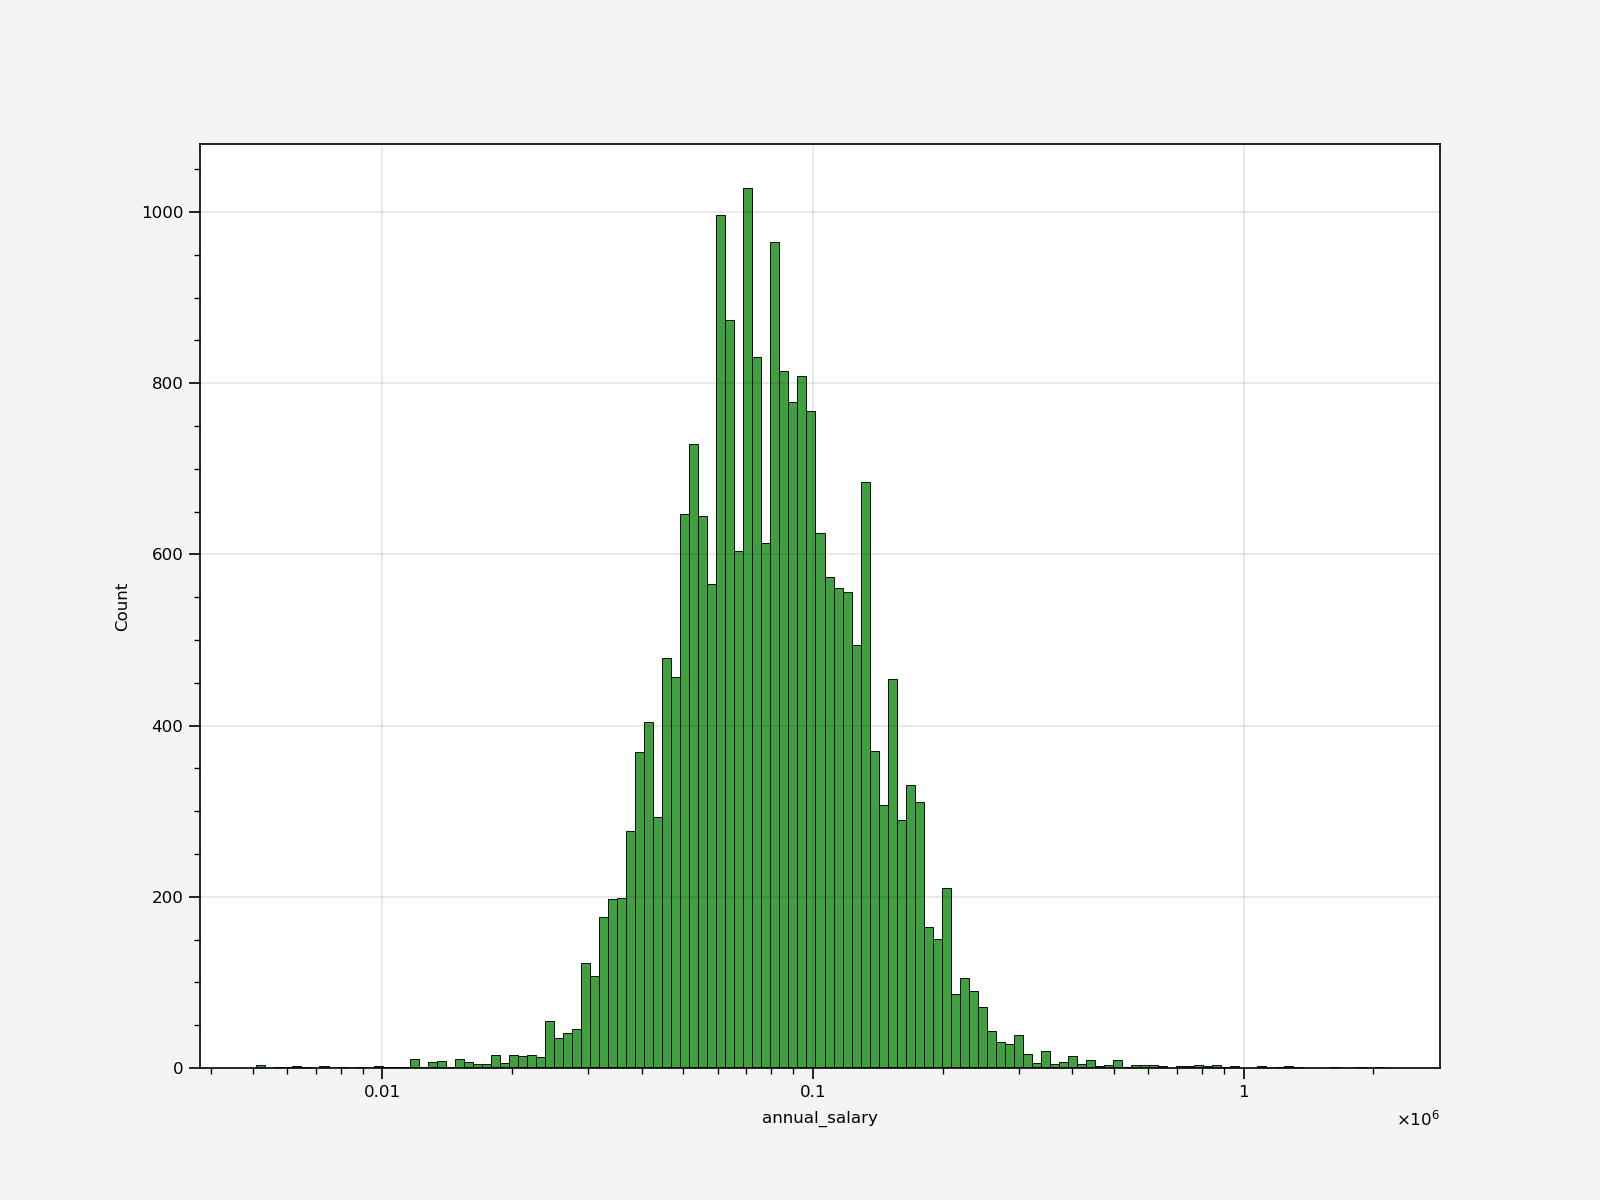

In [209]:
sns.histplot(data=data_usd, x="annual_salary", color='green', log_scale=True);